In [3]:
!$PIP_INSTALL -qq loguru thop lap tqdm cython_bbox

## Import

In [18]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -p jupyterlab,ipykernel,IPython
%watermark -p numpy,sklearn,pandas
%watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
%watermark -p torch,torchvision,torchaudio

%matplotlib inline
# %matplotlib widget

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil, gc
import argparse, shlex, signal
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from cython_bbox import bbox_overlaps as bbox_ious

jupyterlab: 4.0.11
ipykernel : 6.29.0
IPython   : 8.20.0

numpy  : 1.26.3
sklearn: 1.4.0
pandas : 2.2.0

ipywidgets: 8.1.1
cv2       : 4.9.0
PIL       : 10.2.0
matplotlib: 3.8.2
plotly    : 5.18.0
netron    : 7.3.9

torch      : 2.1.1+cu121
torchvision: 0.16.1+cu121
torchaudio : 2.1.1+cu121



## Global

In [19]:
PROJ_TOP_PATH = '/data/source/hzcsai_com/hzcsbet'
DATASETS_PATH = f'{PROJ_TOP_PATH}/gamebet/datasets'
EXTERNAL_LIBS_PATH = f'{PROJ_TOP_PATH}/gamebet/thirdparts'
TEST_VIDEO_PATH = f'{DATASETS_PATH}/0bfacc_5.mp4'
YOLO_WEIGHTS_PATH = f'{PROJ_TOP_PATH}/gamebet/checkpoints/gamebet_yolov8x.pt'

sys.path.append(f'{EXTERNAL_LIBS_PATH}/ByteTrack')
sys.path.append(f'{EXTERNAL_LIBS_PATH}/ultralytics')

IND_TO_CLS = {
    0: "ball",
    1: "player",
    2: "referee",
    3: "goalkeeper",
}

COLORS = {
    "ball": (0, 200, 200),
    "player": (255, 0, 0),
    "goalkeeper": (255, 0, 255),
    "referee": (0, 0, 255),
}

boundaries = [
    ([43, 31, 4], [128, 0, 0], [250, 88, 50]),        # blue
    ([0, 100, 0], [0, 128, 0], [50, 255, 50]),        # green
    ([17, 15, 100], [0, 0, 255], [50, 56, 200]),      # red
    ([192, 192, 0], [192, 192, 0], [255, 255, 128]),  # cyan
    ([192, 0, 192], [192, 0, 192], [255, 128, 255]),  # magenta
    ([0, 192, 192], [0, 192, 192], [128, 255, 255]),  # yellow
    ([0, 0, 0], [0, 0, 0], [50, 50, 50]),             # black
    ([187, 169, 112], [255, 255, 255], [255, 255, 255]),  # white
]

In [37]:
def get_video_frames(video_path):
    video = cv2.VideoCapture(video_path)
    print('width: %d, height: %d, fps: %d, count: %d' % (
        video.get(cv2.CAP_PROP_FRAME_WIDTH),
        video.get(cv2.CAP_PROP_FRAME_HEIGHT),
        video.get(cv2.CAP_PROP_FPS),
        video.get(cv2.CAP_PROP_FRAME_COUNT)))
    frames = []
    while video.isOpened():
        success, frame = video.read()
        if not success:
            break
        frames.append(frame)
    video.release()
    return frames

def detect_color_cv2(image):
    total_pix = 0
    color_idx = -1
    for i, b in enumerate(boundaries):
        mask = cv2.inRange(image, np.array(b[0]), np.array(b[2]))
        output = cv2.bitwise_and(image, image, mask=mask)
        nonzero = np.count_nonzero(output)
        if nonzero > total_pix:
            total_pix = nonzero
            color_idx = i
    return boundaries[color_idx][1]

def draw_detections(image, detections, draw_tacker_id: bool = False):
    image = image.copy()
    for pred in detections:
        x1, y1, x2, y2 = pred.boxes.xyxy.int().tolist()[0]
        color = detect_color_cv2(image_org[y1:y2, x1:x2])
        cls_ind = pred.boxes.cls.int().item()
        cls = IND_TO_CLS[cls_ind]
        cv2.rectangle(img=image, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=3)
        if draw_tacker_id:
            cv2.putText(image, str(pred.tracker_id), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 3)
        else:
            cv2.putText(image, cls, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 3)
    return image


def _imshow(image, title=None, color='bgr', figsize=(6, 3), canvas=False):
    import IPython
    plt.close('all')
    if figsize == 'auto':
        ih, iw = image.shape[:2]
        fw, fh = int(1.5 * iw / 80) + 1, int(1.5 * ih / 80) + 1
        if fw > 32:
            fh = int(32 * (fh / fw))
            fw = 32
        figsize = (fw, fh)
    if canvas:
        IPython.get_ipython().enable_matplotlib(gui='widget');
        fig = plt.figure(figsize=figsize)
        fig.canvas.toolbar_position = 'left'
        fig.canvas.toolbar_visible = True
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
    else:
        IPython.get_ipython().enable_matplotlib(gui='inline')
        fig = plt.figure(figsize=figsize)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if color == 'gray' or len(image.shape) == 2:
        plt.imshow(image, cmap='gray');
    else:
        if color == 'bgr':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image);

def _imgrid(images, nrow=None, padding=4, pad_value=127, labels=None,
            font_scale=1.0, font_thickness=1, text_color=(255,), text_color_bg=None):
    count = len(images)
    if isinstance(images, dict):
        labels = [lab for lab in images.keys()]
        images = [img for img in images.values()]

    if not isinstance(images, (list, tuple, np.ndarray)) or count == 0 or not isinstance(images[0], np.ndarray):
        return
    if nrow is None or nrow > count:
        nrow = count

    max_h, max_w = np.asarray([img.shape[:2] for img in images]).max(axis=0)
    if labels is not None:
        text_org = int(0.1 * max_w), int(0.9 * max_h)
        shape_length = 3
    else:
        shape_length = np.asarray([len(img.shape) for img in images]).max()
    lack = count % nrow
    rows = np.intp(np.ceil(count / nrow))
    hpad_size = [max_h, padding] 
    if rows > 1:
        vpad_size = [padding, nrow * max_w + (nrow - 1) * padding]
        if lack > 0:
            lack_size = [max_h, max_w]
    if shape_length == 3:
        hpad_size.append(3)
        if rows > 1:
            vpad_size.append(3)
            if lack > 0:
                lack_size.append(3)
    hpadding = pad_value * np.ones(hpad_size, dtype=np.uint8)
    if rows > 1:
        vpadding = pad_value * np.ones(vpad_size, dtype=np.uint8)
        if lack > 0:
            lack_image = pad_value * np.ones(lack_size, dtype=np.uint8)
            images.extend([lack_image] * lack)
            if labels is not None:
                labels.extend([''] * lack)
    vlist = []
    for i in range(rows):
        hlist = []
        for j in range(nrow):
            if j != 0:
                hlist.append(hpadding)
            timg = images[i * nrow + j].copy()
            th, tw = timg.shape[:2]
            if th != max_h or tw != max_w:
                timg = cv2.resize(timg, (max_w, max_h))
            if len(timg.shape) != shape_length:
                timg = cv2.cvtColor(timg, cv2.COLOR_GRAY2BGR)
            if labels is not None:
                text = str(labels[i * nrow + j])
                if len(text) > 0:
                    if text_color_bg is not None:
                        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
                        pos1 = text_org[0] - int(font_scale * 5), text_org[1] - th - int(font_scale * 5)
                        pos2 = text_org[0] + int(font_scale * 5) + tw, text_org[1] + int(font_scale * 8)
                        cv2.rectangle(timg, pos1, pos2, text_color_bg, -1)
                    cv2.putText(timg, text, text_org, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)
            hlist.append(timg)
        if i != 0:
            vlist.append(vpadding)
        vlist.append(np.hstack(hlist))
    if rows > 1:
        return np.vstack(vlist)
    return vlist[0]

## Yolo

In [21]:
test_frames = get_video_frames(TEST_VIDEO_PATH)
len(test_frames)

width: 1920, height: 1080, fps: 25, count: 750


750

In [24]:
yolo_model = YOLO(YOLO_WEIGHTS_PATH)

In [26]:
image_org = test_frames[0]
test_0_prediction = yolo_model(image_org, conf=0.15)
image_det = draw_detections(image_org, test_0_prediction[0])


0: 384x640 19 players, 2 referees, 27.8ms
Speed: 12.7ms preprocess, 27.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


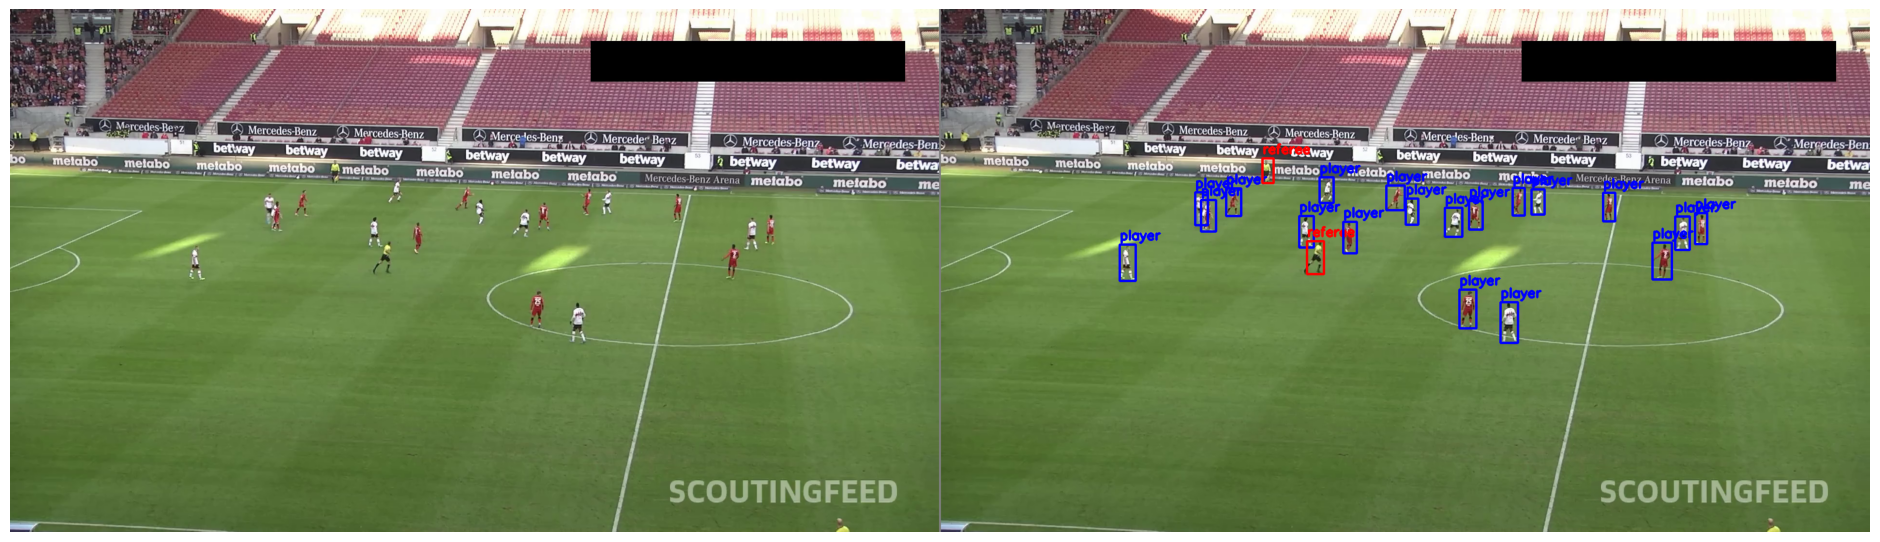

In [39]:
_imshow(_imgrid([image_org, image_det]), figsize=(24, 8))

In [52]:
boundaries = [
    ([43, 31, 4], [128, 0, 0], [250, 88, 50]),    # blue
    ([0, 100, 0], [0, 128, 0], [50, 255, 50]),    # green
    ([17, 15, 100], [0, 0, 255], [50, 56, 200]),  # red
    ([192, 192, 0], [192, 192, 0], [255, 255, 128]),  # cyan
    ([192, 0, 192], [192, 0, 192], [255, 128, 255]),  # magenta
    ([0, 192, 192], [0, 192, 192], [128, 255, 255]),  # yellow
    ([0, 0, 0], [0, 0, 0], [50, 50, 50]),         # black
    ([187, 169, 112], [255, 255, 255], [255, 255, 255]),  # white
]

def detect_color_cv2(image):
    total_pix = 0
    color_idx = -1
    for i, b in enumerate(boundaries):
        mask = cv2.inRange(image, np.array(b[0]), np.array(b[2]))
        output = cv2.bitwise_and(image, image, mask=mask)
        nonzero = np.count_nonzero(output)
        if nonzero > total_pix:
            total_pix = nonzero
            color_idx = i
    return boundaries[color_idx][1]

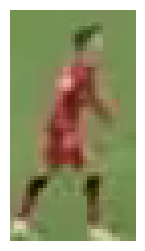

In [59]:
x1, y1, x2, y2 = test_0_prediction[0][0].boxes.xyxy.int().tolist()[0]

image_crop = image_org[y1:y2, x1:x2]
_imshow(image_crop)

In [60]:
detect_color_cv2(image_crop)

[0, 0, 255]

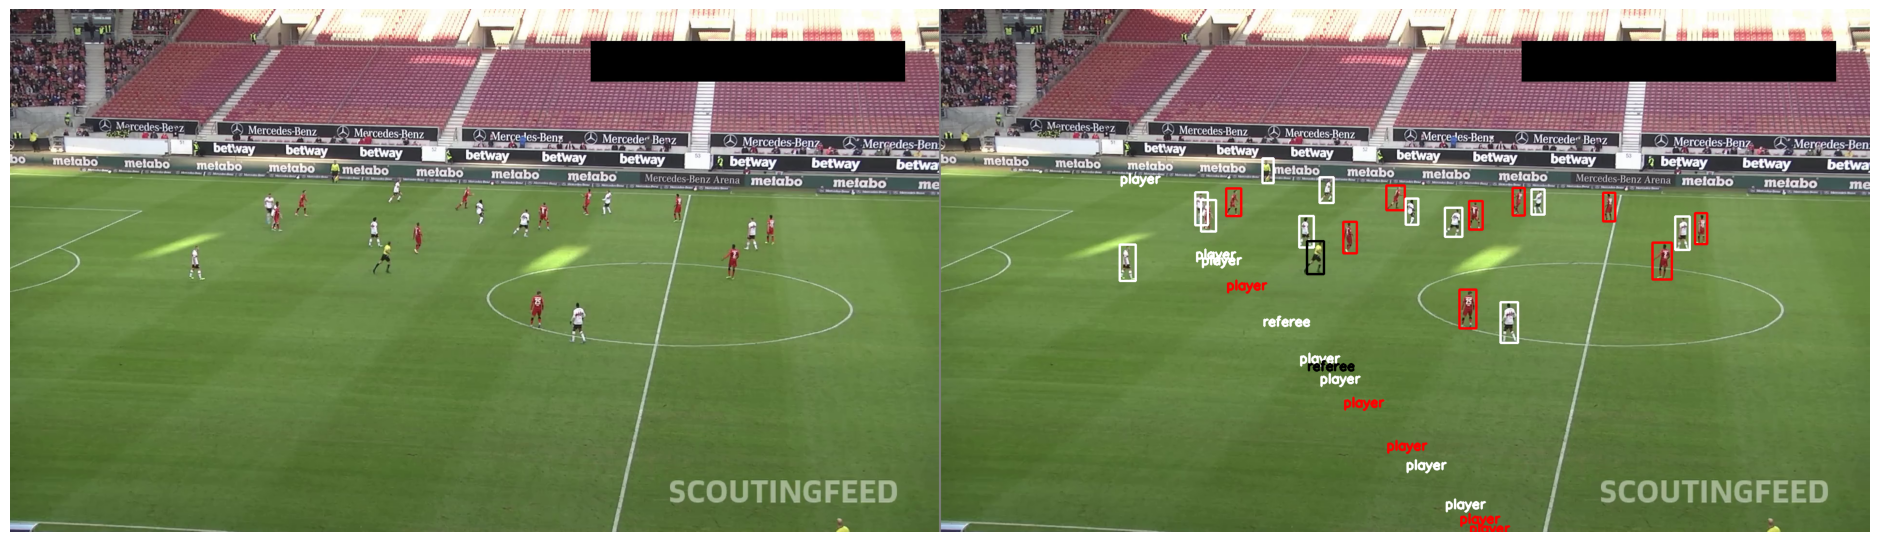

In [63]:
def draw_detections(image, detections, draw_tacker_id: bool = False):
    image = image.copy()
    for pred in detections:
        x1, y1, x2, y2 = pred.boxes.xyxy.int().tolist()[0]
        color = detect_color_cv2(image_org[y1:y2, x1:x2])
        cls_ind = pred.boxes.cls.int().item()
        cls = IND_TO_CLS[cls_ind]
        cv2.rectangle(img=image, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=3)
        if draw_tacker_id:
            cv2.putText(image, str(pred.tracker_id), (x1, x1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 3)
        else:
            cv2.putText(image, cls, (x1, x1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 3)
    return image


image_det = draw_detections(image_org, test_0_prediction[0])
_imshow(_imgrid([image_org, image_det]), figsize=(24, 8))

## References

1. https://readmedium.com/into-football-analytics-how-to-track-football-players-using-yolov8-2d64ed31199c
2. https://teamcolorcodes.com/nfl-team-color-codes/
3. https://www.kaggle.com/code/alvinai9603/extract-jersey-colour-for-team-clustering